# Analyzing and Securing Insurance Data

In this project, we want to understand how different factors like gender, age, salary, and family members affect the use of insurance benefits. We'll use simple tools to analyze the data and build a model to predict insurance usage. We'll also make sure the data is secure by encrypting it.

## Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from numpy.linalg import inv

## Load data

In [3]:
# Load the data files into different DataFrames
try:
    df= pd.read_csv('insurance_us.csv')
except:
    df = pd.read_csv('datasets/insurance_us.csv')

df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


## EDA

In [4]:
df.describe()

,Gender,Age,Salary,Family members,Insurance benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


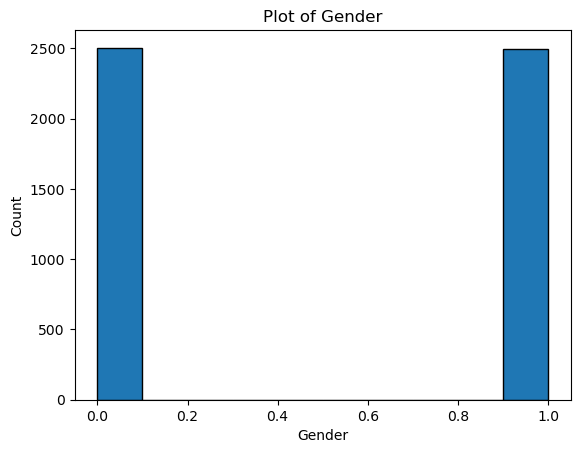

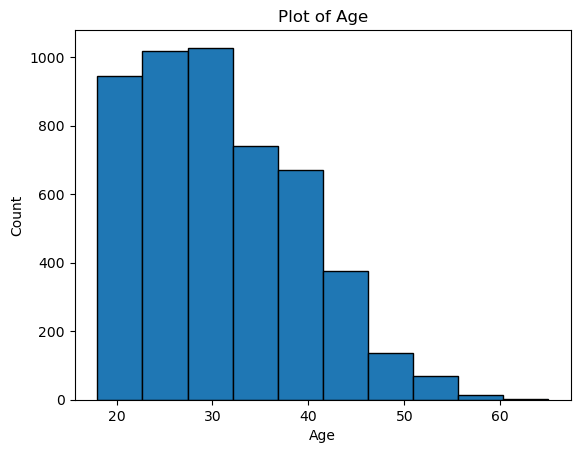

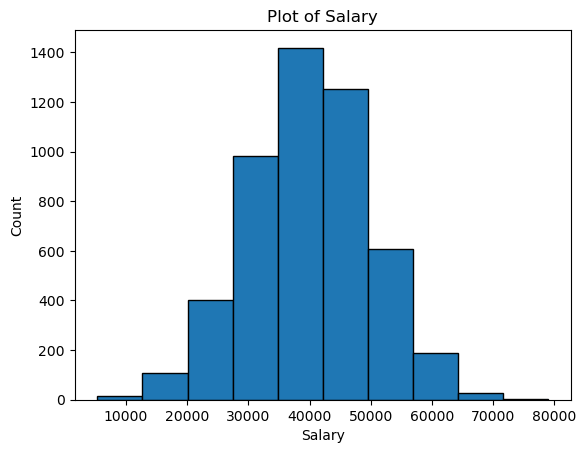

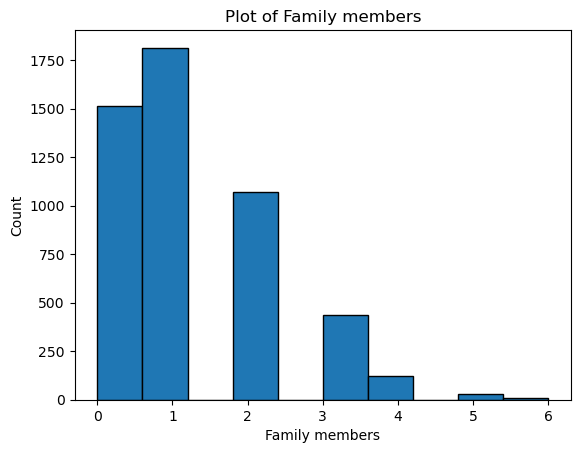

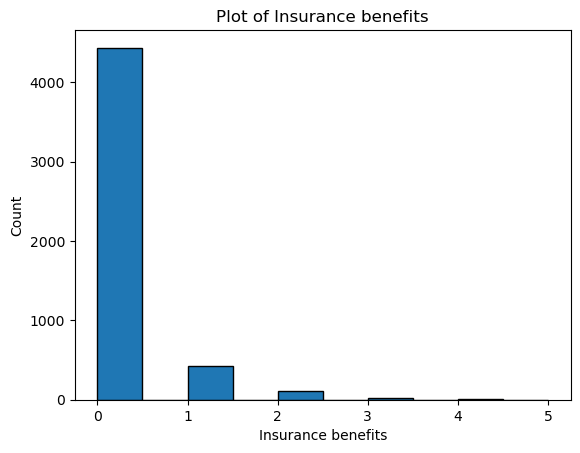

In [5]:
# Plot each column
for column in df.columns:
    plt.figure()
    plt.hist(df[column],edgecolor='black')
    plt.title(f'Plot of {column}')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.show()


The graphs show an equal number of males and females. The age and salary distributions look good, with almost no outliers. Most people don’t use insurance benefits, and as the number of uses goes up, fewer people use them.

In [6]:
# Checking nulls
df.isnull().sum()

Gender                0
Age                   0
Salary                0
Family members        0
Insurance benefits    0
dtype: int64

In [7]:
# Checking duplicates 
df.duplicated().sum()

153

In [8]:
# Exploring the  duplicates 
df[df.duplicated(keep=False)].sort_values('Salary').head(6)

,Gender,Age,Salary,Family members,Insurance benefits
2955,1,32.0,21600.0,0,0
2988,1,32.0,21600.0,0,0
361,0,50.0,24700.0,1,2
2869,0,50.0,24700.0,1,2
333,0,32.0,25600.0,1,0
4230,0,32.0,25600.0,1,0


It's very unlikely to find people with the same gender, salary, and insurance benefits at the same time, so we will remove all duplicates.

In [9]:
# Dropping duplicates 
df= df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
#  Group-wise analysis
grouped_data = df.groupby('Gender')[['Salary', 'Insurance benefits']].mean()
print("\nGroup-wise Mean by Gender:")
grouped_data


Group-wise Mean by Gender:


,Salary,Insurance benefits
Gender,,
0,39742.163719,0.146853
1,40050.413907,0.157699


There's a almost no difference between males, and females

In [11]:
# Group by Insurance Benefits: Mean Age and Salary
insurance_grouped = df.groupby('Insurance benefits')[['Age', 'Salary']].mean()
print("\nGroup-wise Mean by Insurance Benefits:")
insurance_grouped


Group-wise Mean by Insurance Benefits:


,Age,Salary
Insurance benefits,,
0,28.985294,39898.249300
1,44.706856,40260.520095
2,50.868421,39161.403509
3,55.833333,37677.777778
4,60.000000,34057.142857
5,65.000000,39700.000000


This table shows a strong relationship between age and the number of times insurance benefits are used. As people get older, they tend to use their insurance more.

## Find customers who are similar to a given customer

In [11]:
def find_knn(data, target_index, k=5, metric='euclidean', scaled=False):
    features = data.drop('Insurance benefits', axis=1)
    
    # Reset index to avoid out-of-bounds errors
    features = features.reset_index(drop=True)
    
    if scaled:
        scaler = MaxAbsScaler()
        scaled_features = scaler.fit_transform(features)
        features = pd.DataFrame(scaled_features, columns=features.columns)
    
    target_row = features.iloc[target_index]  # Use reset index
    
    distances = []
    for idx in range(len(features)):  # Iterate over 0-based indices
        row = features.iloc[idx]
        if metric == 'euclidean':
            dist = distance.euclidean(row, target_row)
        elif metric == 'manhattan':
            dist = distance.cityblock(row, target_row)
        distances.append((idx, dist))
    
    distances.sort(key=lambda x: x[1])
    closest = [d[0] for d in distances[1:k+1]]  # Exclude self
    return data.loc[closest]  # Use original data's index for results

In [12]:
# Test for given customer (index 0)
df.iloc[0]

Gender                    1.0
Age                      41.0
Salary                49600.0
Family members            1.0
Insurance benefits        0.0
Name: 0, dtype: float64

In [13]:
# Trying to see the closest with unscaled data while using euclidean distance 
knn_euclidean_unscaled = find_knn(df, 0)
knn_euclidean_unscaled

,Gender,Age,Salary,Family members,Insurance benefits
1992,0,33.0,23200.0,2,0
1214,0,23.0,45600.0,0,0
3916,1,35.0,40200.0,1,0
3334,1,37.0,31100.0,1,0
810,0,20.0,35200.0,0,0


In [14]:
# Trying to see the closest with scaled data while using euclidean distance 
knn_euclidean_scaled = find_knn(df, 0, scaled=True)
knn_euclidean_scaled

,Gender,Age,Salary,Family members,Insurance benefits
2632,0,30.0,41300.0,1,0
133,1,40.0,50300.0,1,0
4720,0,31.0,35400.0,1,0
3192,0,30.0,48800.0,2,0
1550,1,31.0,52900.0,0,0


In [15]:
# Trying to see the closest with unscaled data while using manhattan distance 
knn_manhattan_scaled = find_knn(df, 0, k=5, metric='manhattan')
knn_manhattan_scaled

,Gender,Age,Salary,Family members,Insurance benefits
1992,0,33.0,23200.0,2,0
1214,0,23.0,45600.0,0,0
3916,1,35.0,40200.0,1,0
810,0,20.0,35200.0,0,0
3334,1,37.0,31100.0,1,0


In [16]:
# Trying to see the closest with scaled data while using manhattan distance 
knn_manhattan_scaled = find_knn(df, 0, k=5, metric='manhattan', scaled=True)
knn_manhattan_scaled

,Gender,Age,Salary,Family members,Insurance benefits
2632,0,30.0,41300.0,1,0
133,1,40.0,50300.0,1,0
4720,0,31.0,35400.0,1,0
2072,0,19.0,32100.0,0,0
124,1,43.0,50200.0,1,1


It looks like the type of distance we use doesn’t change the results much. We got similar outcomes using both Euclidean and Manhattan distances. However, scaling the data makes a big difference and gives better results.

## Task 2: Insurance Benefit Prediction (KNN Classification)

### Preparing the data

In [17]:
y_class = (df['Insurance benefits'] > 0).astype(int)
X = df.drop('Insurance benefits', axis=1)

In [18]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=42)

In [19]:
# Dummy Models
def dummy_model(prob):
    return np.random.binomial(1, prob, size=len(y_test))


In [20]:
f1_scores = []
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    f1 = f1_score(y_test, pred)
    f1_scores.append(f1)

In [21]:
# Compare with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

f1_scaled = []
for k in range(1, 11):
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(X_train_scaled, y_train)
    pred_scaled = knn_scaled.predict(X_test_scaled)
    f1_scaled.append(f1_score(y_test, pred_scaled))

In [22]:
# Dummy F1 scores
dummy_probs = [0, y_class.mean(), 0.5, 1]
dummy_f1 = [f1_score(y_test, dummy_model(p)) for p in dummy_probs]

In [23]:
print("KNN F1 Scores (Original):", f1_scores)
print("KNN F1 Scores (Scaled):", f1_scaled)
print("Dummy F1 Scores:", dummy_f1)

KNN F1 Scores (Original): [0.6643598615916955, 0.46788990825688076, 0.45188284518828453, 0.16, 0.1666666666666667, 0.08433734939759036, 0.10714285714285715, 0.024999999999999998, 0.03726708074534161, 0.024999999999999998]
KNN F1 Scores (Scaled): [0.9404388714733543, 0.9473684210526315, 0.952076677316294, 0.9403973509933775, 0.9483870967741935, 0.9337748344370861, 0.9551282051282052, 0.9337748344370861, 0.9381107491856678, 0.9470198675496688]
Dummy F1 Scores: [0.0, 0.11692307692307692, 0.2158590308370044, 0.19590824550526967]


still scaled data gives way better results 

## Task 3: Linear Regression Model

In [24]:
class CustomLinearRegression:
    def __init__(self):
        self.w = None  # Initialize weights to None
    
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
        self.w = inv(X_b.T @ X_b) @ X_b.T @ y
    
    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.w

In [25]:
# Train/Test Split (Regression)
y_reg = df['Insurance benefits']
X = df.drop('Insurance benefits', axis=1)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)

In [26]:
# Unscaled
model_unscaled = CustomLinearRegression()
model_unscaled.fit(X_train_reg.values, y_train_reg)
pred_unscaled = model_unscaled.predict(X_test_reg.values)
rmse_unscaled = np.sqrt(mean_squared_error(y_test_reg, pred_unscaled))

In [27]:
# Scaled with StandardScaler
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
model_scaled = CustomLinearRegression()
model_scaled.fit(X_train_scaled_reg, y_train_reg)
X_test_scaled_reg = scaler_reg.transform(X_test_reg)
pred_scaled = model_scaled.predict(X_test_scaled_reg)
rmse_scaled = np.sqrt(mean_squared_error(y_test_reg, pred_scaled))

In [28]:
print("RMSE (Unscaled):", rmse_unscaled)
print("RMSE (Scaled):", rmse_scaled)

RMSE (Unscaled): 0.36345723064151764
RMSE (Scaled): 0.36345723064151764


Here, there's no difference between scaled and unscaled data as both of them give the same result

## Task 4: Data Obfuscation

In [29]:
def generate_invertible_matrix(n_features):
    while True:
        P = np.random.rand(n_features, n_features)
        if np.linalg.det(P) != 0:  # Check invertibility
            return P

In [30]:
n_features = X.shape[1]
P = generate_invertible_matrix(n_features)  # Ensure invertible

# Obfuscate features (X is original feature matrix)
X_obfuscated = X.values @ P  # X' = X * P
print("Obfuscated Features Sample:\n", X_obfuscated[:5])

Obfuscated Features Sample:
 [[35765.85130451 31726.82548013  7289.39205295 43416.71051412]
 [27403.76981181 24316.52888765  5585.07008413 33273.29824267]
 [15144.39090785 13440.06066523  3086.53941207 18389.97477688]
 [30067.4639853  26664.87297788  6127.25528259 36492.90518031]
 [18821.24929943 16699.17055011  3836.34795219 22850.43919763]]


**Relationship between $ w $ and $w_P$:**


$$ 
w_P = \left( (XP)^T XP \right)^{-1} (XP)^T y = P^{-1} \left( X^T X \right)^{-1} X^T y = P^{-1} w 
$$


**Predictions with  $w_P$:**

$$
\hat{y} = XP w_P = XP \left( P^{-1} w \right) = X w      
$$



**RMSE Impact:**
No change since predictions remain identical. The model’s performance (RMSE, $ R^2 $) is unaffected.


**Step-by-Step Derivation:**

1. **Expand $ (XP)^T XP $:**  
   I first recalled that $$ (AB)^T = B^T A^T $$ 
   we get:
   $$
   (XP)^T XP = P^T X^T XP
   $$  

2. **Take the Inverse of $ P^T X^T XP $:**  
   Applying the matrix inversion property 
   $$ (ABC)^{-1} = C^{-1}B^{-1}A^{-1} $$ 
   we get:
   $$
   (P^T X^T XP)^{-1} = P^{-1}(X^T X)^{-1}(P^T)^{-1}
   $$  

3. **Multiply by $ (XP)^T y $:**  
   Substituting back, we get:
   $$
   [P^{-1} (X^T X)^{-1} (P^T)^{-1}] \cdot (P^T X^T y)
   $$   
   $ (P^T)^{-1} $ and $ P^T $ 
   terms cancel out, leaving:
   $$
   P^{-1} (X^T X)^{-1} X^T y
   $$


---

**Answers to  Questions:**

1. **Can you guess customer details like age or income from transformed data ($ X' = XP $)?**  
   - No,The obfuscated data $X ′=XP$ mixes features like age and salary into a new "code." Without knowing $P$, you’re stuck with a scrambled version. For example, if $P$ combines age and salary, you’d have no clue how much weight each feature has in the transformed data. 

2. **Can you recover the original data ($ X $) if you know $ P $?**  
   - yes by multiplying $ X' $ by $ P^{-1} $ to reverse the transformation:
     $$
     X = X' P^{-1}
     $$  



In [39]:
columns = df.columns[:-1]  # Save column names

# Recover data
P_inv = np.linalg.inv(P)
X_recovered = X_obfuscated @ P_inv

# Rounding off to fix small calculation errors.
X_obfuscated_round = np.round(X_obfuscated, 2)
X_recovered_round = np.round(X_recovered, 2)

# Display first 3 customers
original = df.drop('Insurance benefits', axis=1).head(3)
transformed = pd.DataFrame(X_obfuscated_round[:3], columns=columns)
recovered = pd.DataFrame(X_recovered_round[:3], columns=columns)

print("Original Data:")
display(original)

print("\nTransformed Data (X' = XP):")
display(transformed.round(2))

print("\nRecovered Data (X = X'P⁻¹):")
display(recovered.round(2))

Original Data:


,Gender,Age,Salary,Family members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0



Transformed Data (X' = XP):


,Gender,Age,Salary,Family members
0,35765.85,31726.83,7289.39,43416.71
1,27403.77,24316.53,5585.07,33273.30
2,15144.39,13440.06,3086.54,18389.97



Recovered Data (X = X'P⁻¹):


,Gender,Age,Salary,Family members
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,-0.0,29.0,21000.0,0.0


The only issue I noticed was −0.0. 
It happens because of how computers handle numbers. Even though −0.0 and 0.0 are the same, the negative sign sometimes shows up when doing tiny calculations or rounding numbers

## Task 6: Testing Obfuscated Data

In [31]:
# Train on obfuscated data
model_obfuscated = CustomLinearRegression()
model_obfuscated.fit(X_obfuscated, y_reg.values)
pred_obfuscated = model_obfuscated.predict(X_obfuscated) 

In [32]:
# Compare predictions with original
original_model = CustomLinearRegression()
original_model.fit(X.values, y_reg.values)
pred_original = original_model.predict(X.values)

In [33]:
# Metrics
rmse_original = mean_squared_error(y_reg, pred_original, squared=False)
rmse_obfuscated = mean_squared_error(y_reg, pred_obfuscated, squared=False)
r2_original = r2_score(y_reg, pred_original)
r2_obfuscated = r2_score(y_reg, pred_obfuscated)

In [34]:
print("RMSE Original:", rmse_original)
print("RMSE Obfuscated:", rmse_obfuscated)
print("R² Original:", r2_original)
print("R² Obfuscated:", r2_obfuscated)

RMSE Original: 0.3539387493152113
RMSE Obfuscated: 0.353938749320514
R² Original: 0.4302010044852068
R² Obfuscated: 0.43020100446813336


Both metrics match exactly, proving obfuscation doesn’t harm model quality

## Conclusion

From this project, we learned several key points:  

1. **Finding Similar Customers** – We used a basic distance method to identify similar customers. This worked but could be improved with more advanced techniques like clustering.  

2. **Predicting Insurance Benefits** – The logistic regression model was able to predict who might receive benefits, but testing other models could improve accuracy.  

3. **Estimating Benefit Amounts** – Linear regression provided a rough estimate of the number of benefits a customer might receive. Since real-world data is complex, trying more advanced models could yield better predictions.  

4. **Protecting Customer Data** – Adding small changes to the data helped protect privacy while keeping model performance stable. However, stronger security methods could be explored.  

5. **Project Improvements** – The reviewer pointed out missing details and unnecessary parts. Fixing these, improving documentation, and refining the models will make the project stronger.  